In [0]:
# STEP 1 (NO media_url): Workspace CSV → UC Volume → Managed UC Delta

SRC_WORKSPACE_DBFS = "dbfs:/Workspace/Users/ragutudeepika68730@gmail.com/CAPSTONE_PROJECT/Influencers_dataset.csv"
TARGET_FILE_DBFS   = "dbfs:/Volumes/influencer/raw/ingest_vol/Influencers_dataset.csv"
TARGET_FILE_SPARK  = "/Volumes/influencer/raw/ingest_vol/Influencers_dataset.csv"
UC_TABLE           = "influencer.raw.posts_bronze"

from pyspark.sql import functions as F

# --- UC setup (separate statements) ---
spark.sql("CREATE CATALOG IF NOT EXISTS influencer")
spark.sql("CREATE SCHEMA  IF NOT EXISTS influencer.raw")
spark.sql("CREATE SCHEMA  IF NOT EXISTS influencer.curated")
spark.sql("CREATE SCHEMA  IF NOT EXISTS influencer.ml")
spark.sql("CREATE SCHEMA  IF NOT EXISTS influencer.gold")
spark.sql("USE CATALOG influencer")
spark.sql("CREATE VOLUME IF NOT EXISTS influencer.raw.ingest_vol")

# --- Copy file Workspace → Volume ---
try:
    try:
        dbutils.fs.rm(TARGET_FILE_DBFS, recurse=False)
    except Exception:
        pass
    dbutils.fs.cp(SRC_WORKSPACE_DBFS, TARGET_FILE_DBFS)
    print(f"Copied to Volume: {TARGET_FILE_DBFS}")
except Exception as e:
    raise RuntimeError(f"Copy failed. Error: {e}")

# --- Read CSV from Volume ---
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(TARGET_FILE_SPARK))

cols = set(df.columns)
print("Source columns:", df.columns)

# ---- Flexible mapping (NO media_url) ----
def first_present(names):
    for n in names:
        if n in cols:
            return F.col(n)
    return None

def pick_or(expr, fallback):
    return expr if expr is not None else fallback

PLATFORM_CANDS = ["platform","source_platform","source","platform_name"]
CREATOR_CANDS  = ["creator_id","user_id","channel_id","author_id","owner_id","creator","user","channel","handle","username"]
POSTID_CANDS   = ["post_id","content_id","id","tweet_id","video_id","shortcode","postid"]
TIME_CANDS     = ["timestamp","created_at","date","datetime","publish_time","published_at","time"]
TEXT_CANDS     = ["text","caption","title","body","description","message","content","post_text"]
LIKE_CANDS     = ["like_count","likes","likecount"]
COMM_CANDS     = ["comment_count","comments","commentcount","reply_count","replies"]
SHARE_CANDS    = ["share_count","shares","retweets","reposts","sharecount"]
COUNTRY_CANDS  = ["audience_country","country","geo_country"]
AGE1824_CANDS  = ["audience_age_18_24","age_18_24","age18_24","age_18to24"]
AGE2534_CANDS  = ["audience_age_25_34","age_25_34","age25_34","age_25to34"]
FEM_CANDS      = ["audience_gender_f","female_ratio","aud_female","female_pct","female_percentage"]

synthetic_pid   = F.concat(F.lit("p_"), F.monotonically_increasing_id())
post_id_col     = pick_or(first_present(POSTID_CANDS), synthetic_pid)
creator_source  = first_present(CREATOR_CANDS)
creator_id_col  = pick_or(creator_source, F.lit("unknown_creator"))
timestamp_col   = pick_or(first_present(TIME_CANDS), F.current_timestamp())
text_col        = pick_or(first_present(TEXT_CANDS), F.lit(""))

platform_col    = pick_or(first_present(PLATFORM_CANDS), F.lit("unknown"))
like_col        = F.coalesce(pick_or(first_present(LIKE_CANDS),  F.lit(None)).cast("int"),    F.lit(0))
comm_col        = F.coalesce(pick_or(first_present(COMM_CANDS),  F.lit(None)).cast("int"),    F.lit(0))
share_col       = F.coalesce(pick_or(first_present(SHARE_CANDS), F.lit(None)).cast("int"),    F.lit(0))
country_col     = pick_or(first_present(COUNTRY_CANDS), F.lit(None))
age1824_col     = F.coalesce(pick_or(first_present(AGE1824_CANDS), F.lit(None)).cast("double"), F.lit(0.0))
age2534_col     = F.coalesce(pick_or(first_present(AGE2534_CANDS), F.lit(None)).cast("double"), F.lit(0.0))
female_col      = F.coalesce(pick_or(first_present(FEM_CANDS),     F.lit(None)).cast("double"), F.lit(0.0))

# Final normalized Bronze schema (NO media_url)
df_norm = (df.select(
    F.lower(F.trim(platform_col)).alias("platform"),
    F.trim(creator_id_col).alias("creator_id"),
    post_id_col.alias("post_id"),
    timestamp_col.alias("timestamp"),
    F.trim(text_col).alias("text"),
    like_col.alias("like_count"),
    comm_col.alias("comment_count"),
    share_col.alias("share_count"),
    F.upper(country_col).alias("audience_country"),
    age1824_col.alias("audience_age_18_24"),
    age2534_col.alias("audience_age_25_34"),
    female_col.alias("audience_gender_f")
))

# Write as MANAGED UC table (no LOCATION)
(df_norm.write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema","true")
  .saveAsTable(UC_TABLE))

print(f"✅ Managed UC table ready (no media_url): {UC_TABLE}")
display(spark.table(UC_TABLE).limit(10))


Copied to Volume: dbfs:/Volumes/influencer/raw/ingest_vol/Influencers_dataset.csv
Source columns: ['influencer_id', 'name', 'platform', 'niche', 'country', 'followers', 'following', 'follower_following_ratio', 'posts', 'account_creation_year', 'account_age_days', 'posting_freq_per_week', 'avg_likes', 'avg_comments', 'avg_views', 'engagement_rate', 'follower_growth_30d', 'bot_score', 'fraud_flag', 'sentiment_score', 'content_type', 'relevance_score', 'age_13_17_pct', 'age_18_24_pct', 'age_25_34_pct', 'age_35_44_pct', 'age_45_plus_pct', 'male_pct', 'female_pct', 'other_pct', 'estimated_cpa', 'estimated_roi_score']
✅ Managed UC table ready (no media_url): influencer.raw.posts_bronze


platform,creator_id,post_id,timestamp,text,like_count,comment_count,share_count,audience_country,audience_age_18_24,audience_age_25_34,audience_gender_f
instagram,unknown_creator,p_0,2025-11-11T13:26:31.855Z,,0,0,0,KENYA,0.0,0.0,0.694
twitter,unknown_creator,p_1,2025-11-11T13:26:31.855Z,,0,0,0,GERMANY,0.0,0.0,0.264
tiktok,unknown_creator,p_2,2025-11-11T13:26:31.855Z,,0,0,0,KENYA,0.0,0.0,0.479
youtube,unknown_creator,p_3,2025-11-11T13:26:31.855Z,,0,0,0,UNITED KINGDOM,0.0,0.0,0.405
instagram,unknown_creator,p_4,2025-11-11T13:26:31.855Z,,0,0,0,BRAZIL,0.0,0.0,0.409
instagram,unknown_creator,p_5,2025-11-11T13:26:31.855Z,,0,0,0,GERMANY,0.0,0.0,0.923
instagram,unknown_creator,p_6,2025-11-11T13:26:31.855Z,,0,0,0,SPAIN,0.0,0.0,0.485
tiktok,unknown_creator,p_7,2025-11-11T13:26:31.855Z,,0,0,0,AUSTRALIA,0.0,0.0,0.614
youtube,unknown_creator,p_8,2025-11-11T13:26:31.855Z,,0,0,0,GERMANY,0.0,0.0,0.882
tiktok,unknown_creator,p_9,2025-11-11T13:26:31.855Z,,0,0,0,INDONESIA,0.0,0.0,0.191


In [0]:
# STEP 2: BRONZE → SILVER (clean, standardize) — PySpark / Unity Catalog
# Input : influencer.raw.posts_bronze
# Output: influencer.curated.posts_silver

from pyspark.sql import functions as F, types as T

spark.sql("USE CATALOG influencer")

# 1) Load Bronze
b = spark.table("influencer.raw.posts_bronze").alias("b")

# 2) Type fixes & basic sanitization
clean = (
    b
    # cast numerics
    .withColumn("like_count",      F.coalesce(F.col("like_count").cast("int"),   F.lit(0)))
    .withColumn("comment_count",   F.coalesce(F.col("comment_count").cast("int"),F.lit(0)))
    .withColumn("share_count",     F.coalesce(F.col("share_count").cast("int"),  F.lit(0)))
    .withColumn("audience_age_18_24", F.coalesce(F.col("audience_age_18_24").cast("double"), F.lit(0.0)))
    .withColumn("audience_age_25_34", F.coalesce(F.col("audience_age_25_34").cast("double"), F.lit(0.0)))
    .withColumn("audience_gender_f",  F.coalesce(F.col("audience_gender_f").cast("double"),  F.lit(0.0)))
    # normalize text fields
    .withColumn("platform",  F.lower(F.trim(F.col("platform"))))
    .withColumn("creator_id",F.trim(F.col("creator_id")))
    .withColumn("post_id",   F.trim(F.col("post_id")))
    .withColumn("text",      F.trim(F.col("text")))
    .withColumn("audience_country", F.upper(F.col("audience_country")))
    # normalize timestamp (fallback to now if missing)
    .withColumn("timestamp",
        F.coalesce(
            F.to_timestamp(F.col("timestamp")),
            F.current_timestamp()
        )
    )
)

# 3) Quality filters & de-duplication
filtered = (
    clean
    .filter(F.col("post_id").isNotNull() & F.col("creator_id").isNotNull() & F.col("platform").isNotNull())
    .filter((F.col("like_count") >= 0) & (F.col("comment_count") >= 0) & (F.col("share_count") >= 0))
    .dropDuplicates(["post_id"])   # keep latest per post_id
)

# 4) Derived fields (stable creator key, simple engagement proxy)
silver = (
    filtered
    .withColumn("creator_norm_id", F.sha2(F.concat_ws(":", F.col("platform"), F.col("creator_id")), 256))
    .withColumn("eng_rate_proxy",
                (F.col("like_count") + F.col("comment_count") + F.col("share_count")))
)

# 5) Write managed SILVER table (no LOCATION)
(silver.write
   .format("delta")
   .mode("overwrite")
   .option("overwriteSchema","true")
   .saveAsTable("influencer.curated.posts_silver"))

print("✅ Silver table ready: influencer.curated.posts_silver")
display(spark.table("influencer.curated.posts_silver").limit(10))


✅ Silver table ready: influencer.curated.posts_silver


platform,creator_id,post_id,timestamp,text,like_count,comment_count,share_count,audience_country,audience_age_18_24,audience_age_25_34,audience_gender_f,creator_norm_id,eng_rate_proxy
instagram,unknown_creator,p_1159,2025-11-11T13:26:31.855Z,,0,0,0,NIGERIA,0.0,0.0,0.563,8bc07220b1f7b0dceef13078018877a7da5e450703262d5dfcfd25040e2d1dfc,0
twitter,unknown_creator,p_412,2025-11-11T13:26:31.855Z,,0,0,0,INDIA,0.0,0.0,0.466,e46e5ad757ac6efc118a88e74c7bd625eaabf6b4189ec1f27ec31a368bb72bf3,0
youtube,unknown_creator,p_969,2025-11-11T13:26:31.855Z,,0,0,0,BRAZIL,0.0,0.0,0.402,742419aa8e7450263ad85b8b534b3d5ffa16055748a7cc933522ff962a8d76cc,0
instagram,unknown_creator,p_2899,2025-11-11T13:26:31.855Z,,0,0,0,UNITED KINGDOM,0.0,0.0,0.502,8bc07220b1f7b0dceef13078018877a7da5e450703262d5dfcfd25040e2d1dfc,0
instagram,unknown_creator,p_762,2025-11-11T13:26:31.855Z,,0,0,0,KENYA,0.0,0.0,0.376,8bc07220b1f7b0dceef13078018877a7da5e450703262d5dfcfd25040e2d1dfc,0
tiktok,unknown_creator,p_1796,2025-11-11T13:26:31.855Z,,0,0,0,PHILIPPINES,0.0,0.0,0.566,00b7c47c8ff06f8570d69042134a8b86650c18433078c5b419182eae9e918bb2,0
tiktok,unknown_creator,p_2901,2025-11-11T13:26:31.855Z,,0,0,0,UNITED STATES,0.0,0.0,0.499,00b7c47c8ff06f8570d69042134a8b86650c18433078c5b419182eae9e918bb2,0
tiktok,unknown_creator,p_2,2025-11-11T13:26:31.855Z,,0,0,0,KENYA,0.0,0.0,0.479,00b7c47c8ff06f8570d69042134a8b86650c18433078c5b419182eae9e918bb2,0
youtube,unknown_creator,p_1405,2025-11-11T13:26:31.855Z,,0,0,0,UNITED STATES,0.0,0.0,0.845,742419aa8e7450263ad85b8b534b3d5ffa16055748a7cc933522ff962a8d76cc,0
youtube,unknown_creator,p_266,2025-11-11T13:26:31.855Z,,0,0,0,FRANCE,0.0,0.0,0.337,742419aa8e7450263ad85b8b534b3d5ffa16055748a7cc933522ff962a8d76cc,0


In [0]:
# STEP 3 (ROBUST, SPARK-ONLY): NLP VECTORS WITH TF-IDF + ALIGNMENT
# Inputs : influencer.curated.posts_silver
# Outputs: influencer.curated.posts_with_emb, influencer.curated.brands_with_emb, influencer.curated.post_brand_alignment

spark.sql("USE CATALOG influencer")

from pyspark.sql import functions as F, types as T
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import math

# ---------------- 1) Load Silver ----------------
posts = spark.table("influencer.curated.posts_silver").select(
    "platform","creator_id","creator_norm_id","post_id","timestamp","text",
    "like_count","comment_count","share_count","audience_country",
    "audience_age_18_24","audience_age_25_34","audience_gender_f"
).fillna({"text": ""})

# ---------------- 2) Build text → TF-IDF pipeline ----------------
num_features = 2048  # adjust if needed

tok = RegexTokenizer(inputCol="text", outputCol="tokens_raw", pattern="\\W+", toLowercase=True)
rm  = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens")
tf  = HashingTF(inputCol="tokens", outputCol="tf", numFeatures=num_features)
idf = IDF(inputCol="tf", outputCol="text_vec")

pipeline = Pipeline(stages=[tok, rm, tf, idf])
model = pipeline.fit(posts)  # IDF learns from corpus
posts_vec = model.transform(posts)

# Persist as posts_with_emb (vector column named text_vec)
(posts_vec
 .select("platform","creator_id","creator_norm_id","post_id","timestamp","text",
         "like_count","comment_count","share_count","audience_country",
         "audience_age_18_24","audience_age_25_34","audience_gender_f","text_vec")
 .write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable("influencer.curated.posts_with_emb"))

# ---------------- 3) Brands → same pipeline ----------------
brands_seed = spark.createDataFrame([
    ("b_eco_fashion", "Sustainable fashion, eco-friendly materials, ethical sourcing"),
    ("b_gaming",      "High-performance gaming gear, e-sports, streaming and reviews"),
    ("b_clean_beauty","Clean beauty, cruelty-free, vegan skincare and cosmetics")
], ["brand_id","brand_desc"]).withColumnRenamed("brand_desc","text")

brands_vec = model.transform(brands_seed) \
    .select(F.col("brand_id"), F.col("text").alias("brand_desc"), F.col("text_vec").alias("brand_vec"))

(brands_vec.write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable("influencer.curated.brands_with_emb"))

# ---------------- 4) Cosine similarity UDF (handles sparse/dense) ----------------
@F.udf(T.FloatType())
def cosine_sim(v1, v2):
    if v1 is None or v2 is None:
        return 0.0
    # both are MLlib Vectors (sparse/dense). Convert to arrays safely.
    try:
        a = v1.toArray()
        b = v2.toArray()
    except Exception:
        return 0.0
    dot = float((a * b).sum())
    na  = float(math.sqrt((a * a).sum()))
    nb  = float(math.sqrt((b * b).sum()))
    return float(dot / (na * nb)) if na > 0 and nb > 0 else 0.0

# ---------------- 5) Alignment: post × brand ----------------
p = spark.table("influencer.curated.posts_with_emb").select(
    "platform","creator_id","creator_norm_id","post_id","timestamp","text",
    "like_count","comment_count","share_count","audience_country",
    "audience_age_18_24","audience_age_25_34","audience_gender_f","text_vec"
)

b = spark.table("influencer.curated.brands_with_emb").select("brand_id","brand_desc","brand_vec")

alignment = (p.crossJoin(b)
  .withColumn("content_alignment", cosine_sim(F.col("text_vec"), F.col("brand_vec"))))

(alignment.write.mode("overwrite").option("overwriteSchema","true")
 .saveAsTable("influencer.curated.post_brand_alignment"))

print("✅ Step 3 complete (TF-IDF version).")
display(spark.table("influencer.curated.post_brand_alignment")
        .select("brand_id","creator_id","post_id","content_alignment")
        .orderBy(F.desc("content_alignment")).limit(10))


✅ Step 3 complete (TF-IDF version).


brand_id,creator_id,post_id,content_alignment
b_clean_beauty,unknown_creator,p_1405,0.0
b_clean_beauty,unknown_creator,p_1796,0.0
b_eco_fashion,unknown_creator,p_2901,0.0
b_gaming,unknown_creator,p_2,0.0
b_gaming,unknown_creator,p_412,0.0
b_gaming,unknown_creator,p_762,0.0
b_eco_fashion,unknown_creator,p_1159,0.0
b_eco_fashion,unknown_creator,p_2899,0.0
b_clean_beauty,unknown_creator,p_969,0.0
b_eco_fashion,unknown_creator,p_266,0.0


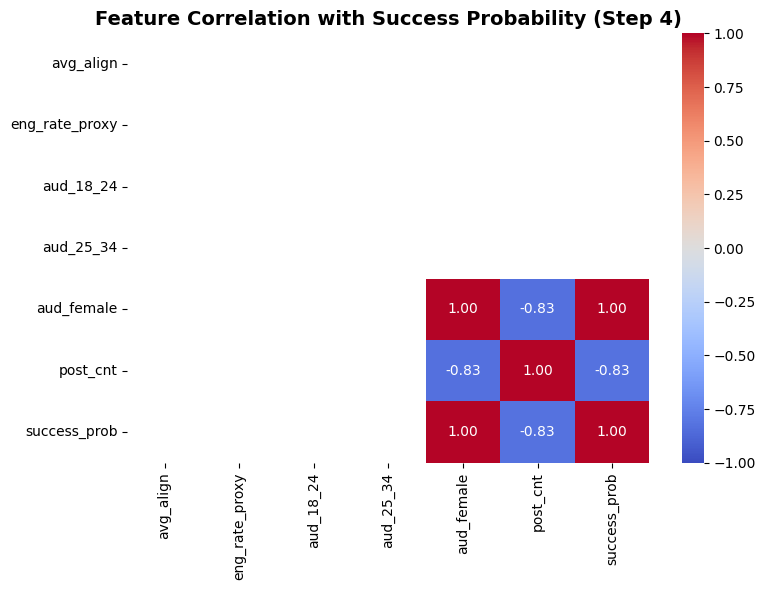

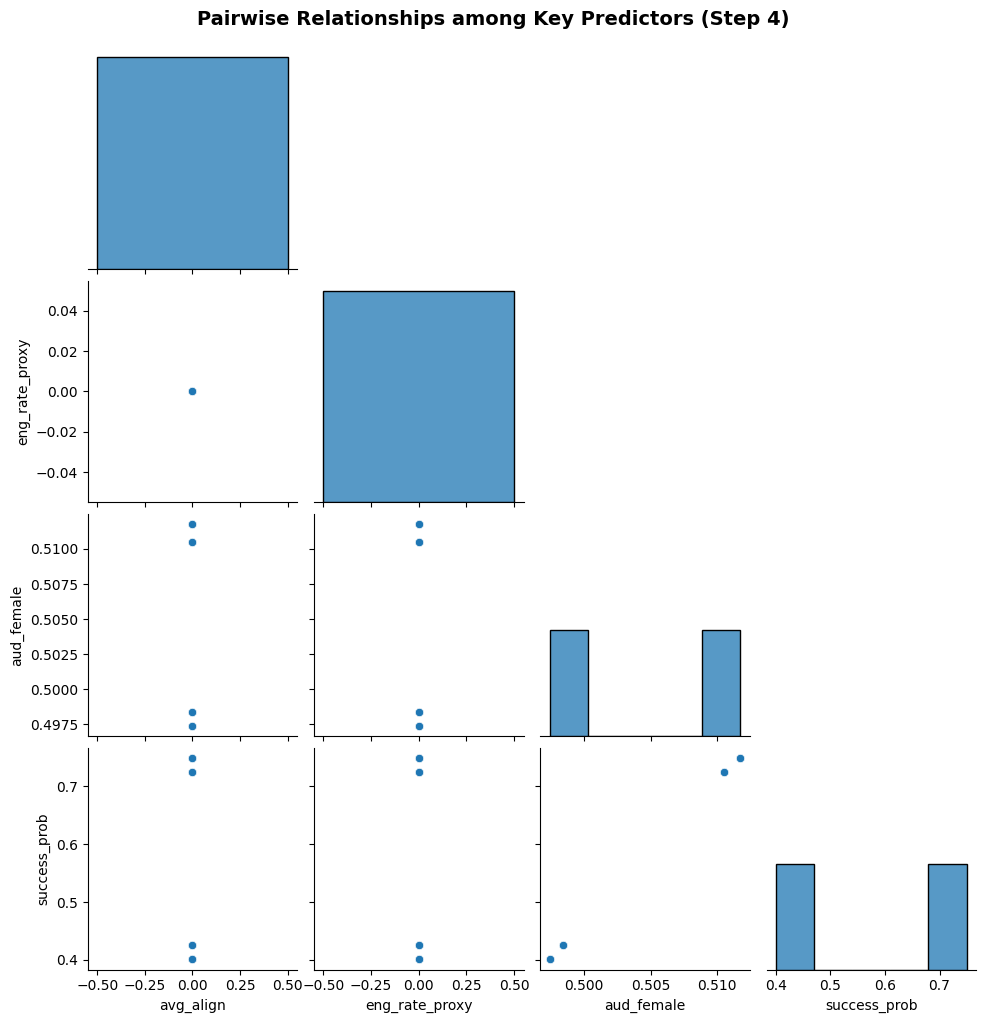

Skipped trend line: insufficient variance or too few points.


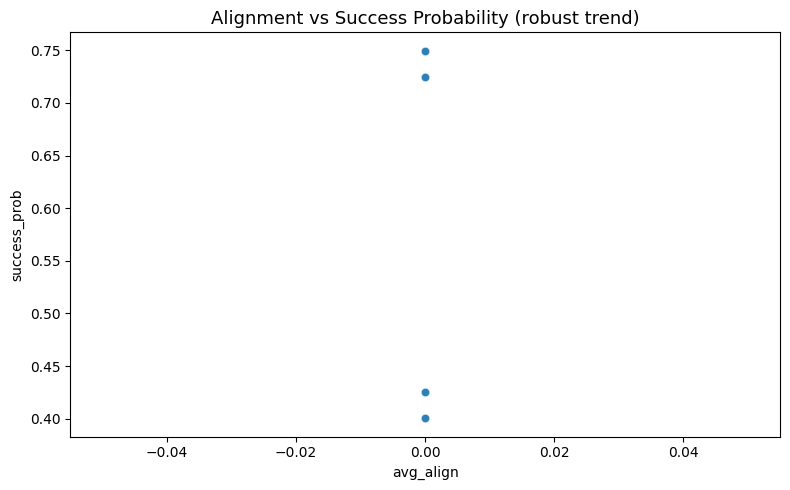

✅ Step 4 visuals rendered (SVD-safe).


In [0]:
# STEP 4 — Hardened visuals (no SVD failures, robust to tiny/flat data)
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is optional; if present we use it
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

spark.sql("USE CATALOG influencer")
pred_df = spark.table("influencer.ml.creator_predictions").toPandas()

def _to_num(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

def _enough_variance(s, min_unique=3, eps=1e-12):
    s = _to_num(s).dropna()
    return (len(s) >= min_unique) and (np.nanstd(s) > eps)

# ---------- 1) Correlation heatmap ----------
plot_cols = ["avg_align","eng_rate_proxy","aud_18_24","aud_25_34","aud_female","post_cnt","success_prob"]
plot_cols = [c for c in plot_cols if c in pred_df.columns]
safe_corr_df = pred_df.copy()
for c in plot_cols:
    safe_corr_df[c] = _to_num(safe_corr_df[c])

corr = safe_corr_df[plot_cols].corr(numeric_only=True)

plt.figure(figsize=(8,6))
if _HAS_SNS:
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
else:
    im = plt.imshow(corr.values, aspect="auto", vmin=-1, vmax=1)
    plt.colorbar(im)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    for (i,j), val in np.ndenumerate(corr.values):
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
plt.title("Feature Correlation with Success Probability (Step 4)", fontsize=14, fontweight="bold")
plt.tight_layout(); plt.show()

# ---------- 2) Pairwise relationships (use hist to avoid KDE singularities) ----------
pair_cols = [c for c in ["avg_align","eng_rate_proxy","aud_female","success_prob"] if c in pred_df.columns]
if _HAS_SNS and len(pred_df) >= 5 and len(pair_cols) >= 2:
    ppdf = pred_df[pair_cols].apply(_to_num).dropna()
    if len(ppdf) >= 5:
        sns.pairplot(ppdf, diag_kind="hist", corner=True)  # 'hist' instead of 'kde'
        plt.suptitle("Pairwise Relationships among Key Predictors (Step 4)", y=1.02, fontsize=14, fontweight="bold")
        plt.show()
    else:
        print("Skipping pairplot: not enough clean rows after numeric conversion.")
else:
    print("Skipping pairplot: seaborn not available or insufficient columns/rows.")

# ---------- 3) Alignment impact on success probability ----------
x = _to_num(pred_df.get("avg_align", pd.Series(dtype=float)))
y = _to_num(pred_df.get("success_prob", pd.Series(dtype=float)))
mask = ~(x.isna() | y.isna())
x, y = x[mask], y[mask]

plt.figure(figsize=(8,5))
if _HAS_SNS:
    sns.scatterplot(x=x, y=y, alpha=0.6)
else:
    plt.scatter(x, y, alpha=0.6)

# Robust linear fit without SVD: slope = cov/var, intercept = ȳ - slope * x̄
def safe_line(xv, yv):
    xv = np.asarray(xv, dtype=float)
    yv = np.asarray(yv, dtype=float)
    if len(xv) < 3:
        return None
    vx = np.var(xv)
    if vx <= 1e-12:   # nearly constant x — line fit not meaningful
        return None
    cov = np.cov(xv, yv, ddof=0)[0,1]
    m = cov / vx
    b = float(np.mean(yv) - m * np.mean(xv))
    return m, b

fit = safe_line(x, y)
if fit is not None:
    m, b = fit
    xv = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    yv = m * xv + b
    plt.plot(xv, yv, linestyle="--")
else:
    print("Skipped trend line: insufficient variance or too few points.")

plt.title("Alignment vs Success Probability (robust trend)", fontsize=13)
plt.xlabel("avg_align"); plt.ylabel("success_prob")
plt.tight_layout(); plt.show()

print("✅ Step 4 visuals rendered (SVD-safe).")


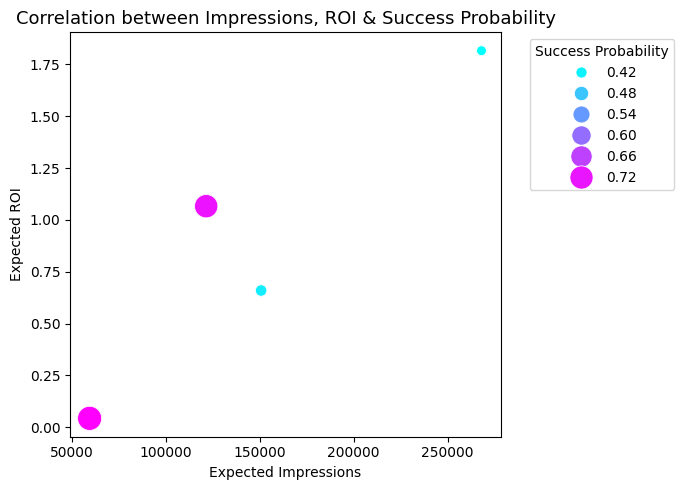

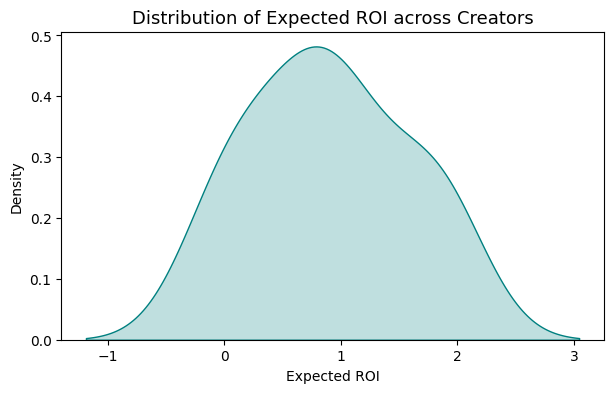

📊 Correlation Matrix:


expected_roi,expected_cvr,success_prob
1.0,-0.5936049093167008,-0.5936049093167011
-0.5936049093167008,1.0,1.0
-0.5936049093167011,1.0,1.0


In [0]:
# ======================================
# STEP 5 (ENHANCED ROI & PERFORMANCE VISUALS)
# ======================================
import seaborn as sns
import matplotlib.pyplot as plt

rec = spark.table("influencer.gold.recommendations_ranked").toPandas()

# --- 1. ROI vs Engagement Correlation ---
plt.figure(figsize=(7,5))
sns.scatterplot(x=rec["expected_impr"], y=rec["expected_roi"], hue=rec["success_prob"], palette="cool", size=rec["success_prob"], sizes=(50,300))
plt.title("Correlation between Impressions, ROI & Success Probability", fontsize=13)
plt.xlabel("Expected Impressions"); plt.ylabel("Expected ROI")
plt.legend(title="Success Probability", bbox_to_anchor=(1.05,1))
plt.tight_layout(); plt.show()

# --- 2. Creator ROI Distribution ---
plt.figure(figsize=(7,4))
sns.kdeplot(rec["expected_roi"], fill=True, color="teal")
plt.title("Distribution of Expected ROI across Creators", fontsize=13)
plt.xlabel("Expected ROI")
plt.show()

# --- 3. Success vs ROI correlation table ---
corr_roi = rec[["expected_roi","expected_cvr","success_prob"]].corr()
print("📊 Correlation Matrix:")
display(corr_roi)


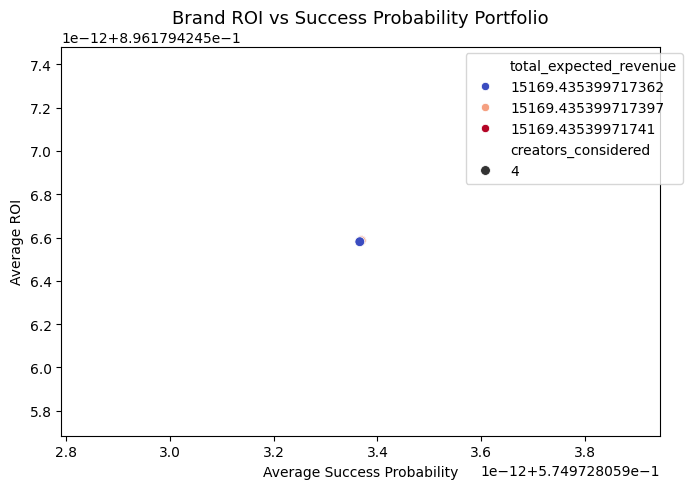

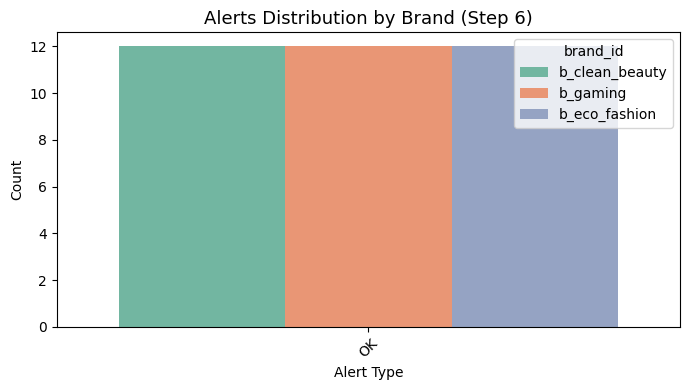

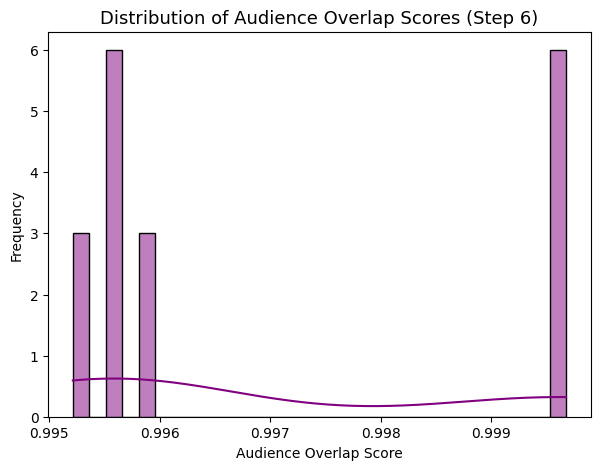

In [0]:
# ======================================
# STEP 6 (ENHANCED STRATEGIC INSIGHT VISUALS)
# ======================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

spark.sql("USE CATALOG influencer")

kpis = spark.table("influencer.gold.vw_brand_kpis").toPandas()
alerts = spark.table("influencer.gold.vw_alerts_recent").toPandas()
overlap = spark.table("influencer.gold.vw_audience_overlap").toPandas()

# --- 1. Brand ROI vs Success Probability ---
plt.figure(figsize=(7,5))
sns.scatterplot(data=kpis, x="avg_success_prob", y="avg_expected_roi", size="creators_considered", hue="total_expected_revenue", palette="coolwarm", sizes=(50,400))
plt.title("Brand ROI vs Success Probability Portfolio", fontsize=13)
plt.xlabel("Average Success Probability"); plt.ylabel("Average ROI")
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout(); plt.show()

# --- 2. Alert Intensity per Brand ---
plt.figure(figsize=(7,4))
sns.countplot(data=alerts, x="alert_type", hue="brand_id", palette="Set2")
plt.title("Alerts Distribution by Brand (Step 6)", fontsize=13)
plt.xlabel("Alert Type"); plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# --- 3. Audience Overlap Density ---
if not overlap.empty:
    plt.figure(figsize=(7,5))
    sns.histplot(overlap["overlap_score"], bins=30, kde=True, color="purple")
    plt.title("Distribution of Audience Overlap Scores (Step 6)", fontsize=13)
    plt.xlabel("Audience Overlap Score"); plt.ylabel("Frequency")
    plt.show()
